<a href="https://colab.research.google.com/github/reagenhuskey/cs290/blob/main/notebooks/partnerProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
url = "https://github.com/michaeledge27/CSCI290/raw/refs/heads/main/data/MBA.csv"
MBAdf = pd.read_csv(url)
MBAdf.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


In [48]:
colsInUse = ['gpa', 'major', 'gmat']
mbadf = MBAdf[colsInUse]
mbadf.head()

,gpa,major,gmat
0,3.30,Business,620.0
1,3.28,Humanities,680.0
2,3.30,Business,710.0
3,3.47,STEM,690.0
4,3.35,STEM,590.0


In [49]:
colsInUseNotTarget = ['gpa', 'major']

# Attribute Selection Method

In [50]:
import numpy as np
import math

In [51]:
# Calculate the entropy for a categorical feature
def categorical_entropy(df, target, feature):
    entropyList = []  # List to store entropy values
    uniqueVals = df[feature].unique()  # Get unique values for the feature
    overall = len(df)  # Total number of rows
    for val in uniqueVals:
        entropy = 0  # Initialize entropy for each unique value
        subset_size = len(df[df[feature] == val])  # Size of subset for the current value
        weight = subset_size / overall  # Weight of the subset
        props = df[df[feature] == val][target].value_counts(normalize=True)  # Get the proportion of target values
        for p in props:
          entropy -= weight * (p * math.log2(p))  # Calculate entropy for the current value
          entropyList.append(entropy)  # Append entropy value to the list
    return min(entropyList)  # Return the minimum entropy value

In [52]:
# Calculate the Gini index for a categorical feature
def categorical_gini(df, target, feature):
    giniList = []  # List to store Gini values
    uniqueVals = df[feature].unique()  # Get unique values for the feature
    overall = len(df)  # Total number of rows
    for val in uniqueVals:
        subset_size = len(df[df[feature] == val])  # Size of subset for the current value
        weight = subset_size / overall  # Weight of the subset
        props = df[df[feature] == val][target].value_counts(normalize=True)  # Get the proportion of target values
        gini = 1 - np.sum(np.square(props))  # Calculate Gini for the current value
        giniList.append(weight * gini)  # Append weighted Gini value to the list
    return min(giniList)  # Return the minimum Gini value

In [53]:
# Calculate the entropy for a quantitative feature
def quantitative_entropy(df, target, feature):
    entropyDict = {} # Dict to store entropy values as vals & split points as keys
    uniqueVals = np.sort(df[feature].unique())  # Sorted unique values for the feature
    overall = len(df)  # Total number of rows
    for val in uniqueVals:
        entropy = 0  # Initialize entropy for each unique value
        # Split the data into two subsets: <= val and > val
        left = df[df[feature] <= val][[feature, target]]
        right = df[df[feature] > val][[feature, target]]

        # Calculate the entropy for the left subset
        props_left = left[target].value_counts(normalize=True)
        weight_left = len(left) / overall
        for prop in props_left:
            if prop > 0:
                entropy -= weight_left * prop * math.log2(prop)

        # Calculate the entropy for the right subset
        props_right = right[target].value_counts(normalize=True)
        weight_right = len(right) / overall
        for prop in props_right:
            if prop > 0:
                entropy -= weight_right * prop * math.log2(prop)

        entropyDict[val] = entropy

    best_split = min(entropyDict, key=entropyDict.get) # Find the corresponding split point
    min_entropy = entropyDict[best_split]  # Get the minimum entropy value

    return min_entropy, best_split


In [54]:
# Calculate the Gini index for a quantitative feature
def quantitative_gini(df, target, feature):
    giniDict = {}  # Dictionary to store Gini values and split points.
    uniqueVals = np.sort(df[feature].unique())  # Sorted unique values for the feature
    overall = len(df)  # Total number of rows
    for val in uniqueVals:
        gini = 0  # Initialize Gini index for each unique value
        # Split the data into two subsets: <= val and > val
        left = df[df[feature] <= val][[feature, target]]
        right = df[df[feature] > val][[feature, target]]

        # Calculate the Gini for the left subset
        props_left = left[target].value_counts(normalize=True)
        weight_left = len(left) / overall
        gini_left = 1 - np.sum(np.square(props_left))

        # Calculate the Gini for the right subset
        props_right = right[target].value_counts(normalize=True)
        weight_right = len(right) / overall
        gini_right = 1 - np.sum(np.square(props_right))

        # Combine Gini values and append to the list
        gini = weight_left * gini_left + weight_right * gini_right
        giniDict[val] = gini

    best_split = min(giniDict, key=giniDict.get) # Find the corresponding split point
    min_gini = giniDict[best_split]  # Get the minimum Gini value

    return min_gini, best_split

In [55]:
# Helper function to check if a feature is categorical
def isCategorical(df, feature):
    return df[feature].nunique() < 8  # A feature is considered categorical if it has fewer than 8 unique values


In [92]:
# Main attribute selection method function
def classification_attribute_selection_method(df, target, measure):
    categoricalList = []  # Store results for categorical features
    categoricalFeatureList = []  # Store categorical feature names
    quantitativeList = []  # Store results for quantitative features
    quantitativeFeatureList = []  # Store quantitative feature names
    splitList = []  # Store best split points for quantitative features
    features = df.columns.drop(target)  # Get all features except the target

    for feature in features:
        if isCategorical(df, feature):  # If feature is categorical
            if measure == 'entropy':
                result = categorical_entropy(df, target, feature)
            elif measure == 'gini':
                result = categorical_gini(df, target, feature)
            categoricalList.append(result)
            categoricalFeatureList.append(feature)
        else:  # If feature is quantitative
            if measure == 'entropy':
                min_entropy, best_split = quantitative_entropy(df, target, feature)
                quantitativeList.append(min_entropy)
                splitList.append(best_split)
            elif measure == 'gini':
                min_gini, best_split = quantitative_gini(df, target, feature)
                quantitativeList.append(min_gini)
                splitList.append(best_split)
            quantitativeFeatureList.append(feature)

    # Determine the best feature and split point
    if categoricalList and min(categoricalList) <= min(quantitativeList):
        return categoricalFeatureList[np.argmin(categoricalList)]
    else:
        best_index = np.argmin(quantitativeList)
        return quantitativeFeatureList[best_index], splitList[best_index]

# Mean Squared Error

In [57]:
# Mean Squared Error for quantitative features for regression
def regression_mse_quantitative(df, target, feature):
    mseList = []
    splitPoints = []
    uniqueVals = np.sort(df[feature].unique())
    overall = len(df)

    for val in uniqueVals:
        # Split into left and right subsets
        left = df[df[feature] <= val][target]
        right = df[df[feature] > val][target]

        # Calculate MSE for left and right subsets
        if len(left) > 0:
            mse_left = np.mean((left - left.mean()) ** 2)
        else:
            mse_left = 0

        if len(right) > 0:
            mse_right = np.mean((right - right.mean()) ** 2)
        else:
            mse_right = 0

        # Weighted average of the MSEs
        weight_left = len(left) / overall
        weight_right = len(right) / overall
        mse = weight_left * mse_left + weight_right * mse_right

        mseList.append(mse)
        splitPoints.append(val)

    #return the minimum mean squared errror value as well as the split at the matching index
    min_mse = np.min(mseList)
    best_split = splitPoints[np.argmin(mseList)]
    return min_mse, best_split

In [58]:
# Mean Squared Error for regression with categorical features
def regression_mse_categorical(df, target, feature):
    mseList = []
    splitPoints = []
    uniqueVals = df[feature].unique()
    overall = len(df)

    for val in uniqueVals:
        # Split into left (matching category) and right (not matching category) subsets
        left = df[df[feature] == val][target]
        right = df[df[feature] != val][target]

        # Calculate MSE for left and right subsets
        if len(left) > 0:
            mse_left = np.mean((left - left.mean()) ** 2)
        else:
            mse_left = 0

        if len(right) > 0:
            mse_right = np.mean((right - right.mean()) ** 2)
        else:
            mse_right = 0

        # Weighted average of the MSEs
        weight_left = len(left) / overall
        weight_right = len(right) / overall
        mse = weight_left * mse_left + weight_right * mse_right

        mseList.append(mse)
        splitPoints.append(val)

    # Return the minimum MSE value and the best category split
    min_mse = np.min(mseList)
    best_split = splitPoints[np.argmin(mseList)]
    return min_mse, best_split

# Regression Selection Method

In [104]:
def regression_selection_method(df, target):
    categoricalList = []  # Store results for categorical features
    categoricalFeatureList = []  # Store categorical feature names
    quantitativeList = []  # Store results for quantitative features
    quantitativeFeatureList = []  # Store quantitative feature names
    splitList = []  # Store best split points for quantitative features
    features = df.columns.drop(target)  # Get all features except the target

    for feature in features:
        if isCategorical(df, feature):  # If feature is categorical
            min_mse, _ = regression_mse_categorical(df, target, feature)
            categoricalList.append(min_mse)
            categoricalFeatureList.append(feature)

        else:  # If feature is quantitative
            min_mse, best_split = regression_mse_quantitative(df, target, feature)
            quantitativeList.append(min_mse)
            quantitativeFeatureList.append(feature)
            splitList.append(best_split)

    if categoricalList and min(categoricalList) <= min(quantitativeList):
        return categoricalFeatureList[np.argmin(categoricalList)]
    else:
        best_index = np.argmin(quantitativeList)
        return quantitativeFeatureList[best_index], splitList[best_index]


In [105]:
regression_selection_method(MBAdf, 'gmat')

('gpa', 3.25)

# Attribute Selection Method

In [94]:
def attribute_selection_method(df, target, task, measure=None):
  if task == 'classification':
    return classification_attribute_selection_method(df, target, 'entropy')
  elif task=='regression':
    return regression_selection_method(df, target)
  else:
    raise ValueError("Invalid task. Use 'classification' or 'regression'.")


# Decision Tree Classifier


In [59]:
from sklearn.model_selection import train_test_split

In [60]:
train_set, test_set = train_test_split(MBAdf, test_size = 0.2, shuffle = True)

In [61]:
train_set.columns

Index(['application_id', 'gender', 'international', 'gpa', 'major', 'race',
       'gmat', 'work_exp', 'work_industry', 'admission'],
      dtype='object')

In [62]:
train_set = train_set[['gender', 'gpa', 'major', 'race',
       'gmat', 'work_exp', 'work_industry', 'admission']]

In [63]:
test_set = test_set[['gender', 'gpa', 'major', 'race',
       'gmat', 'work_exp', 'work_industry', 'admission']]

In [64]:
X_train = train_set[['gender', 'gpa', 'major', 'race',
       'gmat', 'work_exp', 'admission']]
y_train = train_set[['work_industry']]

In [65]:
X_test = test_set[['gender', 'gpa', 'major', 'race',
       'gmat', 'work_exp', 'admission']]
y_test = test_set[['work_industry']]

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

In [67]:
MBAdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   application_id  6194 non-null   int64  
 1   gender          6194 non-null   object 
 2   international   6194 non-null   bool   
 3   gpa             6194 non-null   float64
 4   major           6194 non-null   object 
 5   race            4352 non-null   object 
 6   gmat            6194 non-null   float64
 7   work_exp        6194 non-null   float64
 8   work_industry   6194 non-null   object 
 9   admission       1000 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 441.7+ KB


In [68]:
num_attributes = X_train.select_dtypes( include = ['int64','float64']).columns
cat_attributes = X_train.select_dtypes( include = ['object']).columns

In [69]:
trf = [ ('num', StandardScaler(), num_attributes),
       ('cat', OneHotEncoder( handle_unknown='ignore'), cat_attributes) ]
col_transform = ColumnTransformer( transformers = trf )

In [78]:
pipelineClass = Pipeline( steps = [('pre', col_transform),
 ('clf', DecisionTreeClassifier(max_depth=3))])

In [77]:
pipelineReg = Pipeline( steps = [('pre', col_transform),
 ('clf', DecisionTreeRegressor())])

In [82]:
cross_val_score( pipelineClass, X_train, y_train, cv=5, scoring='accuracy')

array([0.26034309, 0.26437941, 0.26236125, 0.26437941, 0.26437941])

In [83]:
model = pipelineClass.fit( X_train, y_train )
model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['gpa', 'gmat', 'work_exp'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'major', 'race', 'admission'], dtype='object'))])),
                ('clf', DecisionTreeClassifier(max_depth=3))])

In [84]:
predictionsClass = pipelineClass.predict( X_test )

[Text(0.5, 0.875, 'x[0] <= 0.015\ngini = 0.861\nsamples = 4955\nvalue = [84.0, 1311.0, 29.0, 351.0, 263.0, 473.0, 134.0, 48.0\n525.0, 325.0, 722.0, 90.0, 27.0, 573.0]'),
 Text(0.25, 0.625, 'x[8] <= 0.5\ngini = 0.86\nsamples = 2501\nvalue = [39.0, 675.0, 15.0, 151.0, 122.0, 253.0, 67.0, 23.0\n289.0, 177.0, 329.0, 54.0, 15.0, 292.0]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'x[0] <= -2.038\ngini = 0.862\nsamples = 2055\nvalue = [33, 549, 12, 122, 102, 224, 58, 21, 239, 150, 250\n42, 12, 241]'),
 Text(0.0625, 0.125, 'gini = 0.857\nsamples = 86\nvalue = [2, 18, 0, 9, 5, 6, 4, 0, 8, 2, 10, 2, 0, 20]'),
 Text(0.1875, 0.125, 'gini = 0.861\nsamples = 1969\nvalue = [31.0, 531.0, 12.0, 113.0, 97.0, 218.0, 54.0, 21.0\n231.0, 148.0, 240.0, 40.0, 12.0, 221.0]'),
 Text(0.375, 0.375, 'x[0] <= -1.177\ngini = 0.848\nsamples = 446\nvalue = [6.0, 126.0, 3.0, 29.0, 20.0, 29.0, 9.0, 2.0, 50.0\n27.0, 79.0, 12.0, 3.0, 51.0]'),
 Text(0.3125, 0.125, 'gini = 0.808\nsamples = 104\nvalue = [2, 35, 0, 6

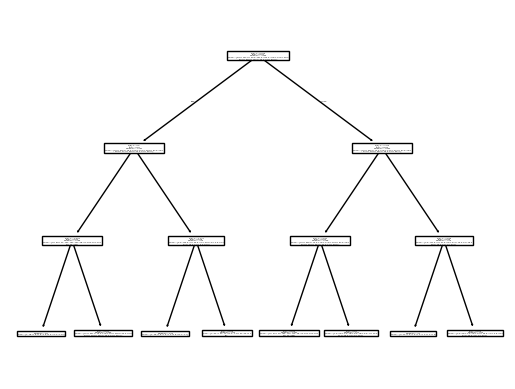

In [85]:
plot_tree( pipelineClass.named_steps['clf'])